Introduction

This analysis aims to guide policymakers in identifying areas of Pennsylvania where resources can be allocated more equitably and effectively. By examining demographic, economic, and environmental data, the goal is to uncover patterns and clusters of counties that highlight disparities and areas of need. The results of this study will provide evidence-based insights to inform resource allocation and policy interventions, particularly in addressing poverty, unemployment, and access to environmental resources like parks.

Research Questions

- Are demographic, economic, and environmental factors spatially correlated across the state of Pennsylvania?

- How can the identification of similar county clusters help policymakers equitably allocate resources?

Data Setup

To answer these research questions, we integrated data from several sources:

American Community Survey (ACS): Using the Census Bureau’s ACS 5-year estimates API, we gathered key demographic and economic indicators for all counties in Pennsylvania. These include:

- Total population

- Median household income
    
- Per capita income
    
- Educational attainment (e.g., high school graduates, bachelor’s degree holders)
    
- Poverty rate
    
- Median housing value
    
- Racial demographics (e.g., white, Black, Hispanic populations)
    
Geospatial Data: We obtained county boundary geometries for Pennsylvania from a GeoJSON file and reprojected the data to Pennsylvania State Plane (EPSG: 2272) for spatial analysis.

Park Data: Data on local park coverage by county was sourced from the Pennsylvania Department of Conservation and Natural Resources (DCNR). Using park acreage, we calculated the percentage of local park area relative to each county’s total area.
    
Unemployment Data: Unemployment rates were extracted from additional datasets and merged with the county-level data.

Data Preparation and Cleaning

- Merging Datasets: The ACS data was merged with geospatial county boundaries using unique identifiers. Additional park and unemployment data were integrated using county names.
    
Derived Variables: Several new variables were calculated to enhance the analysis:

- Percent White, Black, Hispanic populations: Calculated as proportions of the total population.
    
- Educational attainment percentages: Calculated for both high school graduates and bachelor’s degree holders.
    
- Percent Local Park: Calculated as the proportion of county area covered by local parks.
    
- Handling Missing Values: Missing values were handled by imputing medians or zeros for specific variables to ensure compatibility for clustering and other analyses.

Analysis Approach

- Correlation Analysis: A correlation matrix was generated to explore relationships between demographic, economic, and environmental variables.

- Spatial Visualization: Maps were created to visualize spatial patterns in key variables like unemployment rates, poverty levels, and local park coverage.
    
- Clustering Analysis: Using K-means clustering, counties were grouped based on socioeconomic, demographic, and environmental characteristics. This helped identify clusters of counties with similar needs or advantages.
    
- Socioeconomic Index: A composite index was calculated combining median household income, bachelor’s degree attainment, and poverty rate to rank counties based on overall socioeconomic well-being.

Goal and Application

The results of this analysis will:

- Highlight disparities across Pennsylvania counties in income, education, environmental access, and unemployment.

- Identify clusters of counties with shared characteristics to allow targeted policymaking.

- Serve as a resource for state and local governments to allocate resources more equitably, focusing on underserved communities.

In [1]:
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import matplotlib.pyplot as plt

# API Key
API_KEY = '0da0c882151e10740c1a0a844cf845096bedb565'
c = Census(API_KEY)

# Fetch data from the ACS API
acs_data = c.acs5.state_county(
    fields=[
        'NAME',  # County name
        'B01003_001E',  # Total population
        'B15003_001E',  # Population 25+
        'B19013_001E',  # Median household income
        'B19301_001E',  # Per capita income
        'B01002_001E',  # Median age
        'B02001_002E',  # White population
        'B02001_003E',  # African American population
        'B03001_003E',  # Hispanic population
        'B15003_017E',  # High school graduates
        'B15003_022E',  # Bachelor’s degree holders
        'B25077_001E',  # Median housing value
        'B17001_002E',  # Population below poverty line
    ],
    state_fips=states.PA.fips,
    county_fips="*"
)

# Convert the data into a DataFrame
acs_df = pd.DataFrame(acs_data)

# Label columns (accounting for the 'NAME' column as the first column)
acs_df.columns = [
    'County',  # Name of the county
    'Total Population',
    'Population Over 25',
    'Median Household Income', 
    'Per Capita Income', 
    'Median Age', 
    'White Population', 
    'African American Population', 
    'Hispanic Population', 
    'High School Graduates', 
    'Bachelors Degree Holders', 
    'Median Housing Value', 
    'Population Below Poverty Line',
    'State',  
    'County_Name'
]

# Data cleaning
# Remove ' County, Pennsylvania' from the 'County' column and convert to uppercase
acs_df['County'] = acs_df['County'].str.replace(" County, Pennsylvania", "", case=False)
acs_df['County'] = acs_df['County'].str.upper()

# Drop the 'State' column since it's redundant
acs_df.drop(columns=['State'], inplace=True)

In [2]:
# loading counties
geojson_path = "/Users/macytrout/Desktop/Python Final/PaCounty2024_11.geojson"

county_data = gpd.read_file(geojson_path)

# merge counties to acs

counties = county_data.merge(
    acs_df,
    left_on='FIPS_COUNT',
    right_on='County_Name',  # Replace with actual column name in acs_df
    how='left'
)

In [3]:
# Creating new variables
counties['Percent_White'] = counties['White Population'] / counties['Total Population']*100 # Percent white
counties['Percent_Black'] = counties['African American Population'] / counties['Total Population']*100 # Percent black
counties['Percent_Hispanic'] = counties['Hispanic Population'] / counties['Total Population']*100 # Percent hispanic
counties['Percent_HS_degrees'] = counties['High School Graduates'] / counties['Total Population']*100 # Percent high school grads
counties['Percent_Bachelors'] = counties['Bachelors Degree Holders'] / counties['Population Over 25']*100 # Percent bachelors
counties['Percent_Poverty'] = counties['Population Below Poverty Line'] / counties['Population Over 25']*100 # Percent below poverty line

In [4]:
parks_path = "/Users/macytrout/Desktop/Python Final/DCNR_LocalPark202406/DCNR_LocalPark202406.shp"
parks_data = gpd.read_file(parks_path)

parks_data = parks_data.drop(columns=['STATUS', 'PARK_FEE', 'ALT_NAME', 'PREMISE_AD', 'PREMISE_CI', 'PREMISE_ZI', 'YEAR_OPEN',
                                     'PREMISE_CR', 'URL', 'COMMENTS', 'ATV', 'Basketball', 'Bicycling', 'Camping', 'Canoeing_K',
                                     'CrossCount', 'Disc_Golf', 'Dog_Park', 'Equestrian', 'Fishing', 'Fitness_Eq', 'Golf',
                                     'Hiking', 'Horseback_', 'Hunting', 'Ice_Fishin', 'Ice_Skatin', 'Motor_Boat', 'LWCF_Restr',
                                     'Mountain_B', 'Natural_Wi', 'Organized_', 'Parking', 'Pavilion', 'Pets_Allow', 'Playground',
                                     'Restrooms', 'Rock_Climb', 'Scenic_Vie', 'Sledding', 'Sports_Fie', 'Swimming', 'Tennis_Cou',
                                     'Theatre_Am', 'Trails', 'Visitor_Ce', 'White_Wate', 'Wildlife_W', 'Amenity_Co', 'Feedback_l',
                                     'Skate_Park'])

updated_parks = parks_data.groupby('PREMISE_CO')['Acres'].sum().reset_index()
updated_parks['park_sq_mi'] = updated_parks['Acres'] / 640
updated_parks['PREMISE_CO'] = updated_parks['PREMISE_CO'].str.upper()

parks = counties.merge(
    updated_parks,
    left_on='County',  # Column in pa_counties to merge on
    right_on='PREMISE_CO',  # Column in updated_parks to merge on
    how='left')

parks['Percent Local Park'] = parks['park_sq_mi'] / parks['AREA_SQ_MI'] * 100

In [5]:
unemp_data = pd.read_csv("/Users/macytrout/Desktop/Python Final/unemp.csv")
unemp_data['County'] = unemp_data['County'].str.replace('County', '', case=False).str.strip()
unemp_data['County'] = unemp_data['County'].str.upper()

pa_counties = unemp_data.merge(
    parks,
    left_on='County',  # Column in pa_counties to merge on
    right_on='County',  # Column in updated_parks to merge on
    how='left')

pa_counties.rename(columns={"Value (Percent)": "Unemp Rate"}, inplace=True)

pa_counties.head()

,County,FIPS,Unemp Rate,SOUND,MSLINK,MAINT_CTY_,AREA,COUNTY_PER,COUNTY_N_1,NOTE_FILE,...,Percent_White,Percent_Black,Percent_Hispanic,Percent_HS_degrees,Percent_Bachelors,Percent_Poverty,PREMISE_CO,Acres,park_sq_mi,Percent Local Park
0,PHILADELPHIA,42101.0,8.6,NaN,67.0,5,0.0,0.0,67.0,NaN,...,37.086181,40.101920,15.674225,18.039201,18.804105,32.275883,PHILADELPHIA,14743.428866,23.036608,16.054318
1,PIKE,42103.0,8.5,NaN,51.0,4,0.0,0.0,51.0,NaN,...,82.292020,6.047868,11.946573,21.893010,15.568566,13.181716,PIKE,1680.749924,2.626172,0.462356
2,FAYETTE,42051.0,7.2,NaN,26.0,1,0.0,0.0,26.0,NaN,...,90.477118,4.233863,1.386109,30.989666,12.285337,21.231176,FAYETTE,3348.768523,5.232451,0.655030
3,CAMERON,42023.0,7.1,NaN,12.0,4,0.0,0.0,12.0,NaN,...,95.039683,0.044092,2.006173,35.361552,8.688147,19.390104,CAMERON,96.706578,0.151104,0.037816
4,CARBON,42025.0,6.9,NaN,13.0,2,0.0,0.0,13.0,NaN,...,91.753053,2.433172,5.981421,29.374942,12.482574,15.711937,CARBON,3632.510434,5.675798,1.460450


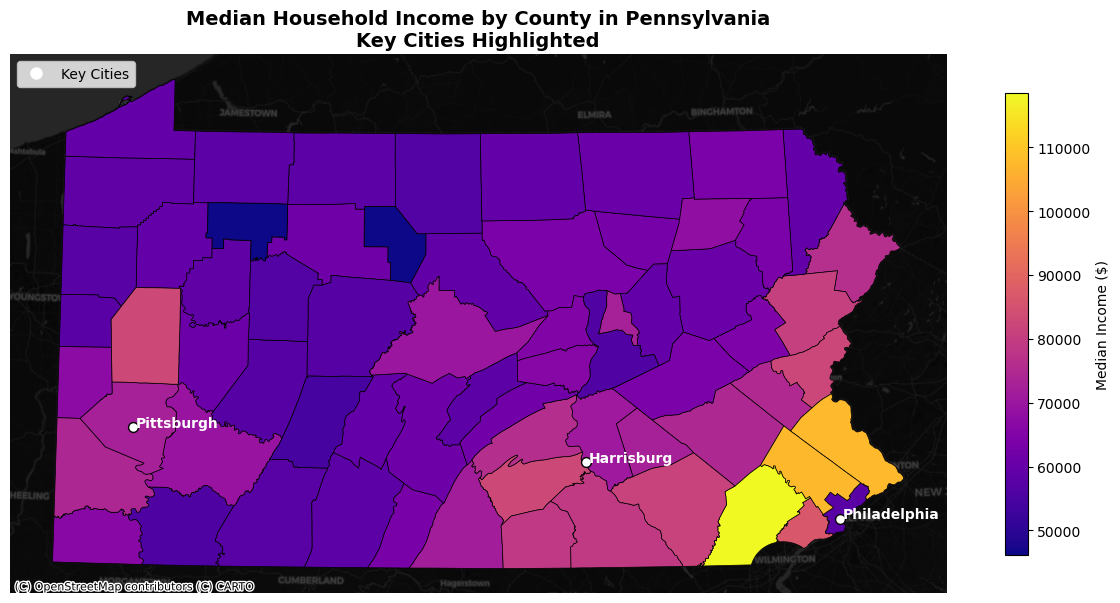

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure pa_counties is a GeoDataFrame
if 'geometry' not in pa_counties.columns:
    raise ValueError("The 'pa_counties' DataFrame must have a 'geometry' column.")

pa_counties = gpd.GeoDataFrame(pa_counties, geometry=pa_counties['geometry'])

# Ensure the GeoDataFrame has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize Median Household Income for color scaling
norm = Normalize(vmin=pa_counties['Median Household Income'].min(), vmax=pa_counties['Median Household Income'].max())

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pa_counties.plot(
    column='Median Household Income',
    cmap='plasma',  # Darker colormap
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Median Income ($)"},
    ax=ax
)

cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")

for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Median Household Income by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()

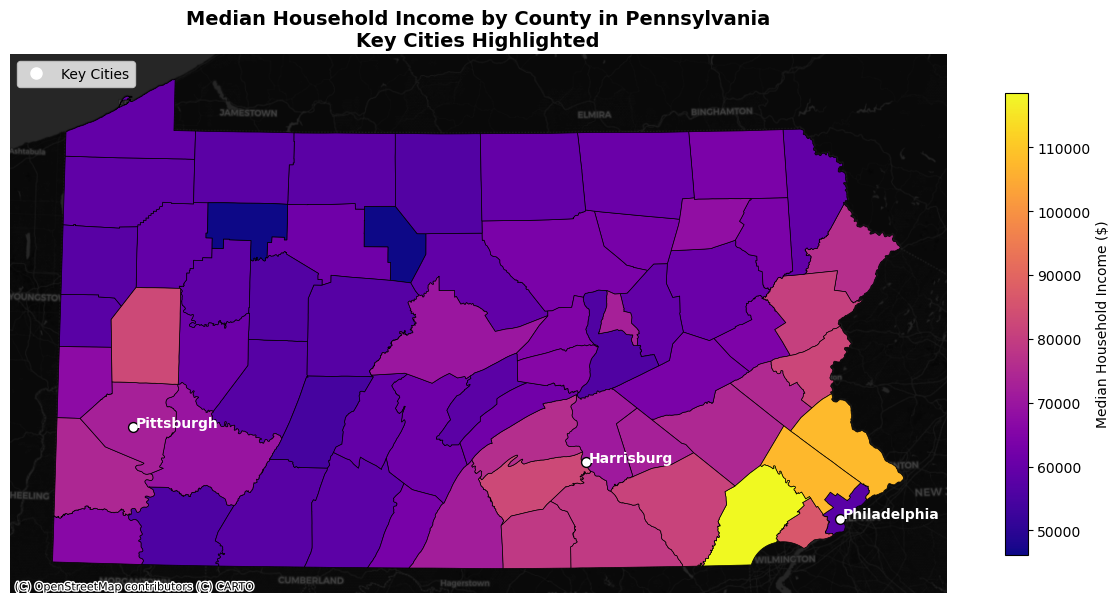

In [7]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure the geometry column in pa_counties has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject pa_counties to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize Median Household Income for color scaling
norm = Normalize(vmin=pa_counties['Median Household Income'].min(), vmax=pa_counties['Median Household Income'].max())

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pa_counties.plot(
    column='Median Household Income',
    cmap='plasma',  # Updated colormap for income
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Median Household Income ($)"},
    ax=ax
)

# Plot key cities
cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")

# Add city labels
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

# Add a dark basemap for better contrast
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for Key Cities
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Add a title and format the map
plt.title("Median Household Income by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

# Show the map
plt.tight_layout()
plt.show()

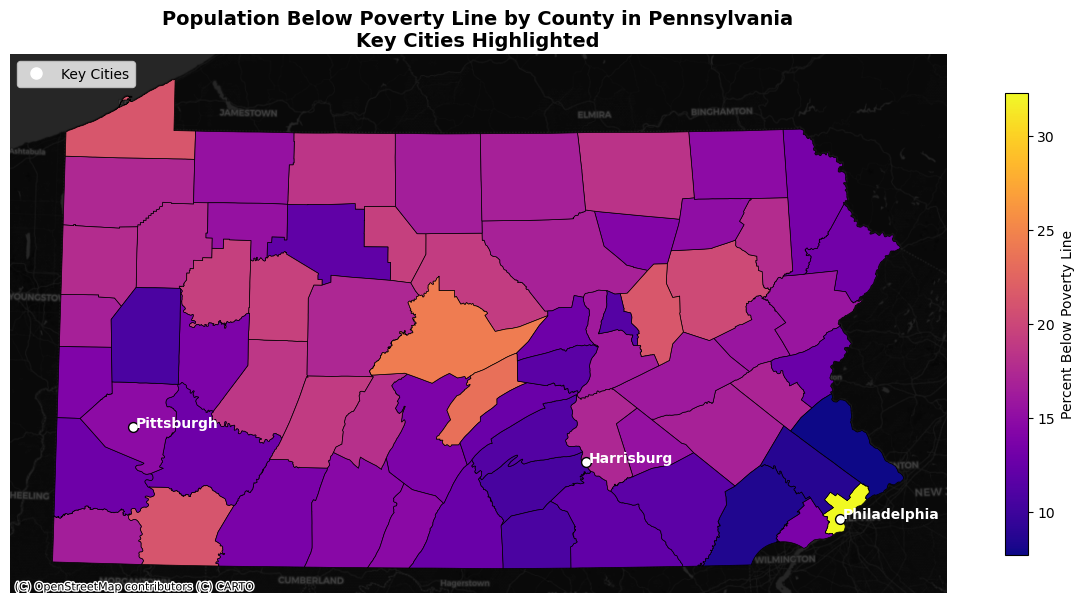

In [8]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure the geometry column in pa_counties has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject pa_counties to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize Percent Poverty for color scaling
norm = Normalize(vmin=pa_counties['Percent_Poverty'].min(), vmax=pa_counties['Percent_Poverty'].max())

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pa_counties.plot(
    column='Percent_Poverty',
    cmap='plasma',  # Updated colormap
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Percent Below Poverty Line"},
    ax=ax
)

# Plot key cities
cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")

# Add city labels
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for Key Cities
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Population Below Poverty Line by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

# Show map
plt.tight_layout()
plt.show()

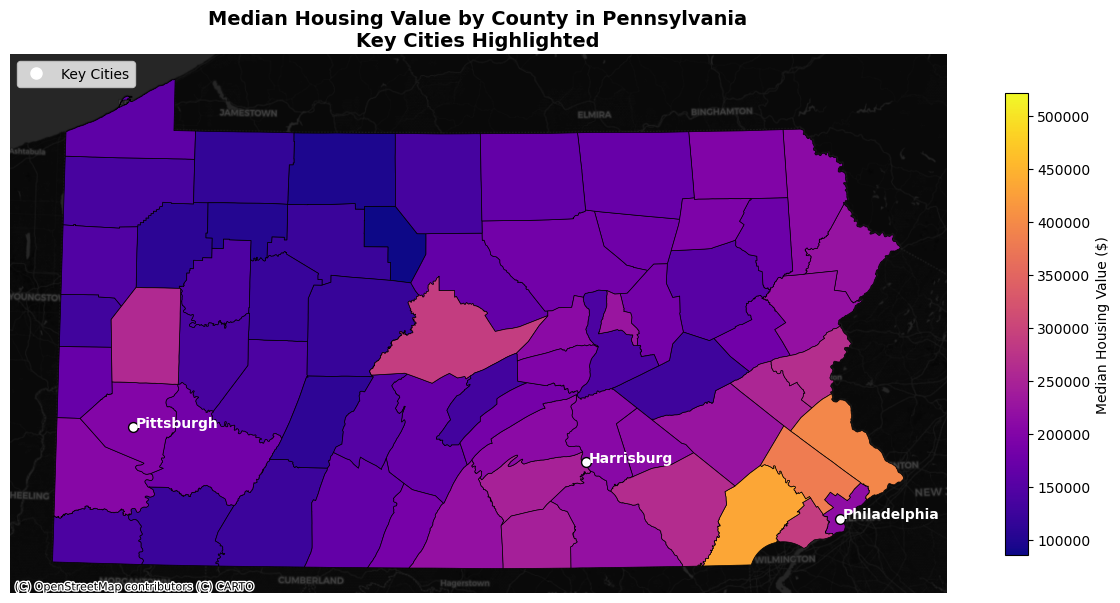

In [9]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure the geometry column in pa_counties has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject pa_counties to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize Median Housing Value for color scaling
norm = Normalize(vmin=pa_counties['Median Housing Value'].min(), vmax=pa_counties['Median Housing Value'].max() * 1.2)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pa_counties.plot(
    column='Median Housing Value',
    cmap='plasma',  # Updated colormap for better visibility
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Median Housing Value ($)"},
    ax=ax
)

# Plot key cities
cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")

# Add city labels
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for Key Cities
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Median Housing Value by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

# Show map
plt.tight_layout()
plt.show()

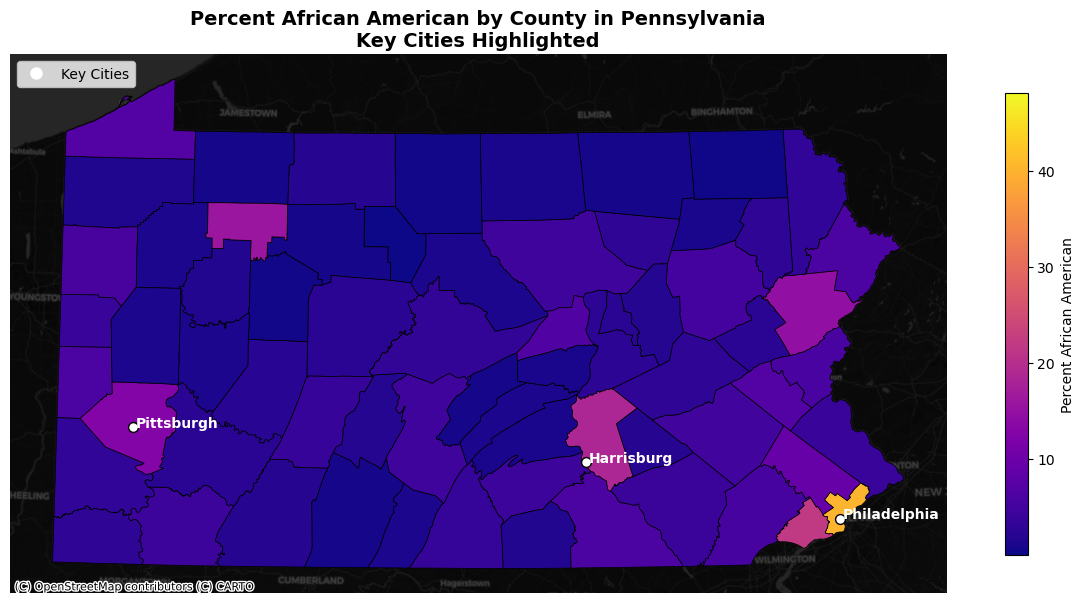

In [10]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure the geometry column in pa_counties has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject pa_counties to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize Percent African American for color scaling
norm = Normalize(vmin=pa_counties['Percent_Black'].min(), vmax=pa_counties['Percent_Black'].max() * 1.2)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pa_counties.plot(
    column='Percent_Black',
    cmap='plasma',  # Updated colormap for better visibility
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Percent African American"},
    ax=ax
)

# Plot key cities
cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")

# Add city labels
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for Key Cities
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Percent African American by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

# Show map
plt.tight_layout()
plt.show()

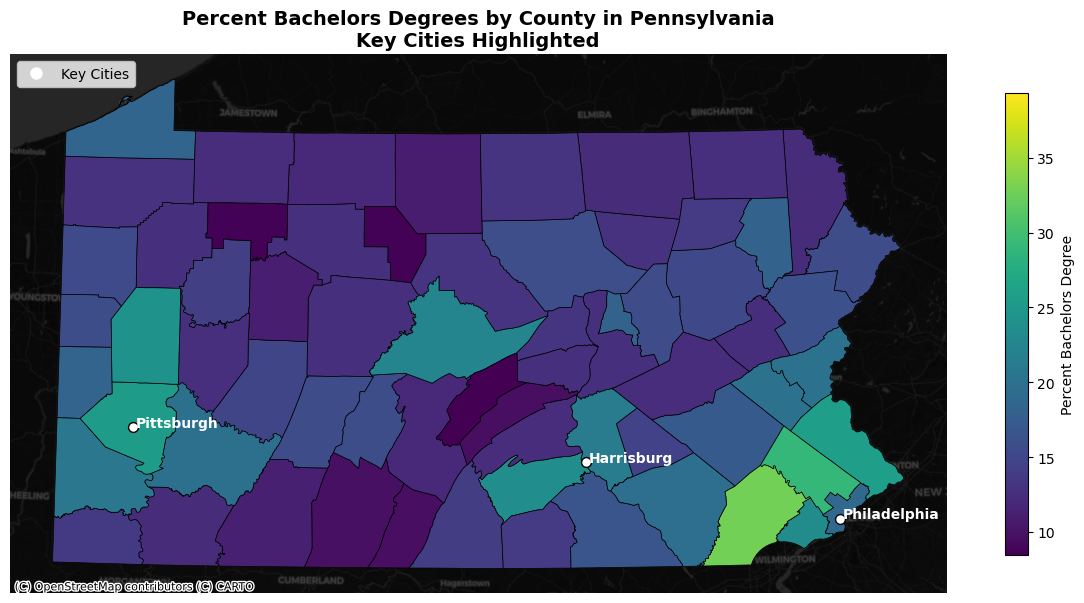

In [11]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure the geometry column in pa_counties has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject pa_counties to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize Percent Bachelors for color scaling
norm = Normalize(vmin=pa_counties['Percent_Bachelors'].min(), vmax=pa_counties['Percent_Bachelors'].max() * 1.2)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pa_counties.plot(
    column='Percent_Bachelors',
    cmap='viridis',  # Updated colormap for better visualization
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Percent Bachelors Degree"},
    ax=ax
)

# Plot key cities
cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")

# Add city labels
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for Key Cities
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Percent Bachelors Degrees by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

# Show map
plt.tight_layout()
plt.show()

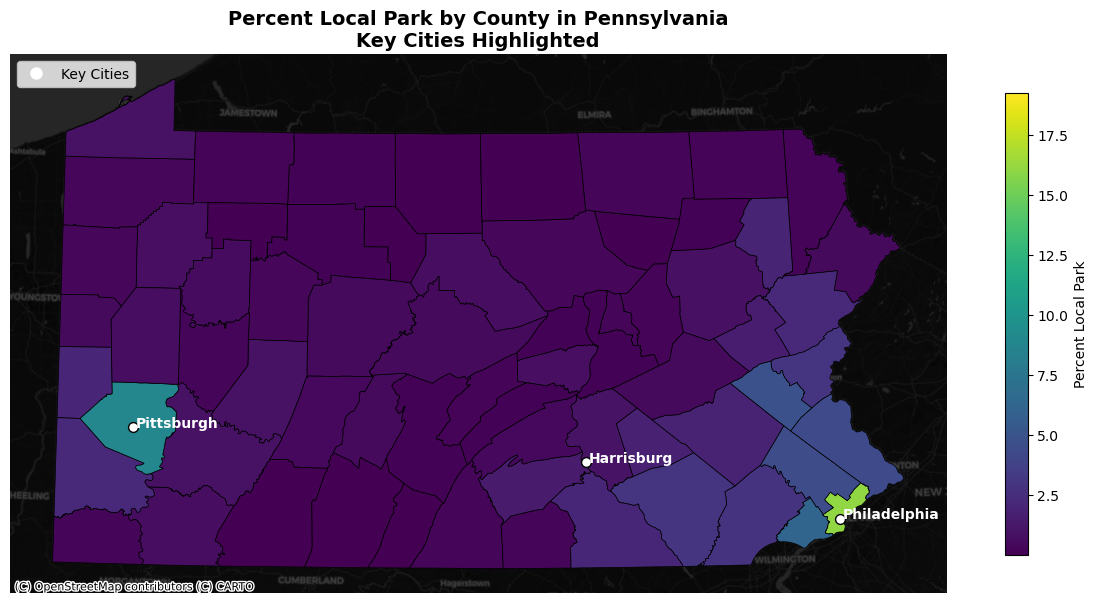

In [12]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure the geometry column in pa_counties has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject pa_counties to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize Percent Local Park for color scaling
norm = Normalize(vmin=pa_counties['Percent Local Park'].min(), vmax=pa_counties['Percent Local Park'].max() * 1.2)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pa_counties.plot(
    column='Percent Local Park',
    cmap='viridis',  # Colormap for better visualization
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    norm=norm,
    legend_kwds={'shrink': 0.6, 'label': "Percent Local Park"},
    ax=ax
)

# Plot key cities
cities_gdf.plot(ax=ax, color='white', markersize=50, edgecolor='black', label="Key Cities")

# Add city labels
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

# Add dark-themed basemap
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for Key Cities
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Add title and finalize the layout
plt.title("Percent Local Park by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

# Show map
plt.tight_layout()
plt.show()

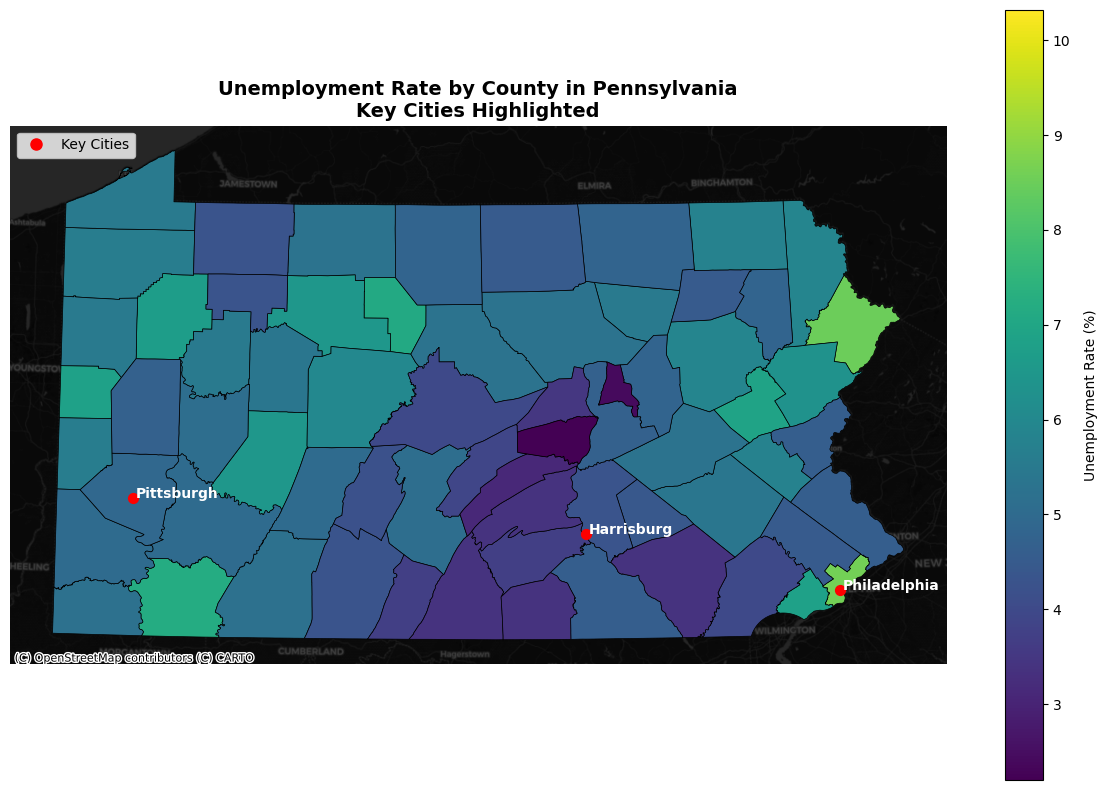

In [13]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure the geometry column in pa_counties has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject pa_counties to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize unemployment data for color mapping
min_unemp = pa_counties['Unemp Rate'].min()
max_unemp = pa_counties['Unemp Rate'].max()
norm = Normalize(vmin=min_unemp, vmax=max_unemp * 1.2)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pa_counties.plot(
    column='Unemp Rate',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.5,
    legend=False,
    norm=norm,
    ax=ax
)

# Add a colorbar manually
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Unemployment Rate (%)", fontsize=10, labelpad=10)

# Plot key cities
cities_gdf.plot(ax=ax, color='red', markersize=50, label="Key Cities")

# Add city labels
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

# Add basemap
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for Key Cities
legend_elements = [Line2D([0], [0], marker='o', color='red', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("Unemployment Rate by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")

# Show map
plt.tight_layout()
plt.show()

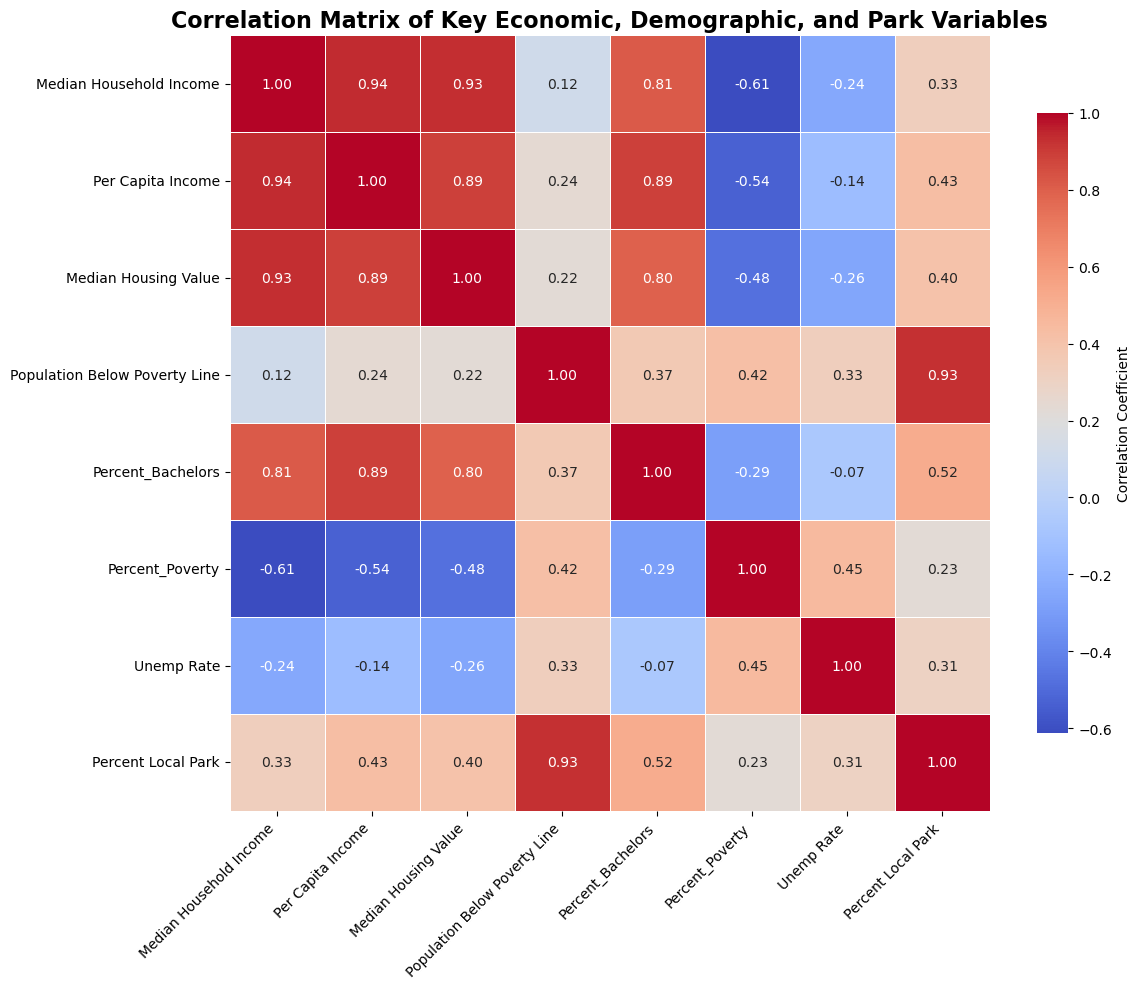

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Refined list of variables for correlation analysis, including park-related variable
refined_vars = [
    'Median Household Income',
    'Per Capita Income',
    'Median Housing Value',
    'Population Below Poverty Line',
    'Percent_Bachelors',
    'Percent_Poverty',
    'Unemp Rate',
    'Percent Local Park'
]

# Create a correlation matrix for the refined variables
refined_correlation_matrix = pa_counties[refined_vars].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    refined_correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)
plt.title("Correlation Matrix of Key Economic, Demographic, and Park Variables", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

This correlation matrix provides a valuable foundation for identifying areas in Pennsylvania where government resources and policies can be more effectively allocated.

Key Insights from the Correlation Matrix:

Strong Positive Relationships Between Income and Education:

- Median Household Income and Percent Bachelors show a strong positive correlation (0.90). This suggests that areas with higher levels of educational attainment tend to have higher household incomes. Policies that promote access to higher education, such as scholarships or workforce training programs, could uplift communities with lower incomes.

- Per Capita Income also correlates positively with Percent Bachelors (0.89), reinforcing this connection.

Inverse Relationship Between Poverty and Income:

- Percent Poverty has a negative correlation with Median Household Income (-0.44) and Per Capita Income (-0.54). Areas with higher poverty rates are likely to have lower incomes. These areas may need targeted economic development programs, job creation initiatives, or social safety nets to reduce poverty levels.

Unemployment and Poverty:

- Unemployment Rate correlates positively with Percent Poverty (0.45) and negatively with income measures (e.g., -0.24 with Median Household Income). High unemployment exacerbates poverty and income disparities. Job training programs and economic revitalization efforts could be prioritized in high-unemployment areas.

Park Accessibility and Socioeconomic Indicators:

- Percent Local Park has a modest positive correlation with Median Household Income (0.26) and Per Capita Income (0.43). This suggests that areas with better park access might also have higher incomes, potentially due to historical investment patterns. Expanding park and recreational opportunities in underserved areas could address inequities and improve quality of life.

Focus on Areas of High Poverty and Low Education:

- Percent Poverty and Population Below Poverty Line are positively correlated (0.42), highlighting a clear need to target these areas. Additionally, Percent Bachelors has a weaker correlation with poverty measures, indicating that educational access might be a key intervention point.

Housing Value as a Proxy for Wealth:

- Median Housing Value correlates strongly with Median Household Income (0.93) and Percent Bachelors (0.80). Housing value could serve as a proxy for identifying wealthier versus underserved areas. Policies could focus on improving housing affordability in high-poverty regions.



	
Actionable Insights for Policy Implementation:


Target High-Poverty, Low-Education Areas:

- Use this correlation matrix to identify counties with high poverty rates and low levels of educational attainment. Allocate resources to provide educational programs and improve access to higher education in these regions.

Expand Parks and Recreational Resources:

- The modest correlation between park access and income highlights the potential for parks to serve as equitable community investments. Focus on areas with limited park access to enhance quality of life and public health.

Job Training and Economic Development:

- Address high unemployment areas by investing in job training and economic opportunities. This can help reduce poverty rates and improve overall economic conditions.

Consider Housing Affordability:

- Explore housing initiatives in areas where Median Housing Value is low but Percent Poverty is high. This might indicate regions where housing needs renovation or redevelopment.


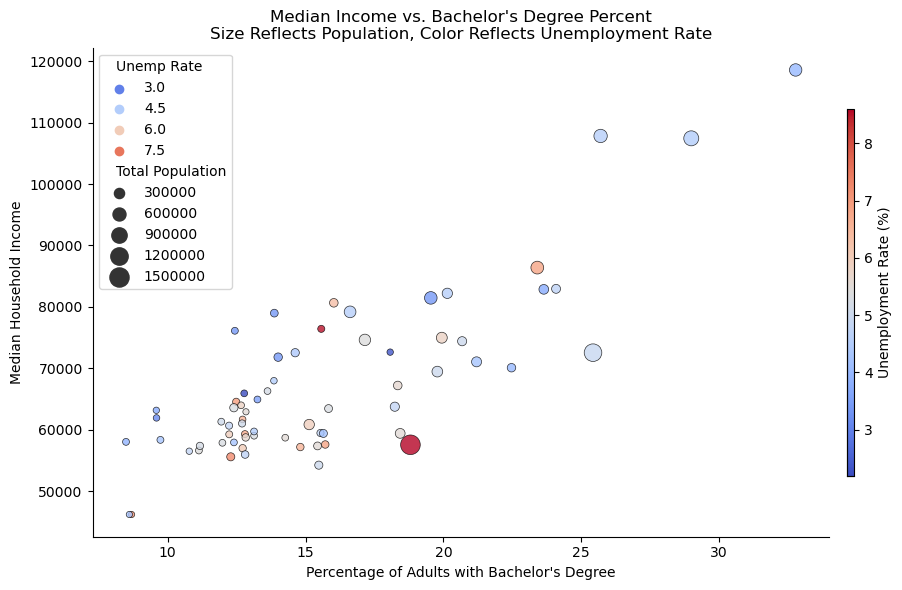

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

scatter = sns.scatterplot(
    data=pa_counties, 
    x='Percent_Bachelors', 
    y='Median Household Income', 
    size='Total Population', 
    hue='Unemp Rate',  # Change hue to Unemployment Rate
    palette='coolwarm', 
    sizes=(20, 200),  
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8, 
    ax=ax
)

norm = plt.Normalize(pa_counties['Unemp Rate'].min(), pa_counties['Unemp Rate'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, aspect=50, shrink=0.75, pad=0.02)
cbar.set_label("Unemployment Rate (%)")

plt.title("Median Income vs. Bachelor's Degree Percent\nSize Reflects Population, Color Reflects Unemployment Rate")
plt.xlabel("Percentage of Adults with Bachelor's Degree")
plt.ylabel("Median Household Income")

sns.despine()

plt.tight_layout()
plt.show()

This scatterplot provides insights into the relationships between median household income, percentage of adults with a bachelor’s degree, unemployment rate, and total population at the county level in Pennsylvania. Here’s what this visualization reveals for the analysis:


Median Income vs. Bachelor’s Degree Attainment:

- Counties with higher percentages of adults holding a bachelor’s degree generally show higher median household incomes. This suggests a strong positive relationship between educational attainment and income levels across Pennsylvania counties.
    
- Some outliers exist where counties with relatively high education levels still have lower median incomes, indicating other influencing factors like industry structure or cost of living.

    
Unemployment Rate (Color Gradient):
    
- The color gradient, ranging from blue (lower unemployment) to red (higher unemployment), highlights that counties with higher bachelor’s degree attainment tend to have lower unemployment rates.
    
- Counties with higher unemployment rates (darker red points) are concentrated in areas with lower income and bachelor’s degree percentages, emphasizing a need for policy interventions in these regions.
    
Population Distribution (Bubble Size):
    
- The bubble size represents the total population of each county. Larger counties (e.g., Philadelphia) are concentrated in regions with relatively higher income and education levels but may also face unique challenges.
    
- Smaller counties are scattered across the spectrum, with varying levels of income, education, and unemployment, indicating that population size alone does not dictate economic outcomes.

Implications for Policy:

- Education and Income: There is a clear need to invest in education as a means to improve median household income. Counties with lower bachelor’s degree attainment could benefit from initiatives to expand access to higher education and workforce development programs.
    
- Unemployment Interventions: Counties with high unemployment rates and lower educational attainment should be prioritized for job creation programs and retraining initiatives.
    
- Resource Allocation: Larger counties with significant population sizes should not overshadow smaller counties in resource allocation, as many smaller counties face substantial challenges in income, education, and employment.
    
- Outliers: Policymakers should also focus on outliers where high educational attainment does not translate into higher income or employment, identifying and addressing structural barriers in these regions.

Overall, this visualization reinforces the interconnectedness of income, education, and employment and provides a data-driven foundation for equitable resource allocation across Pennsylvania.

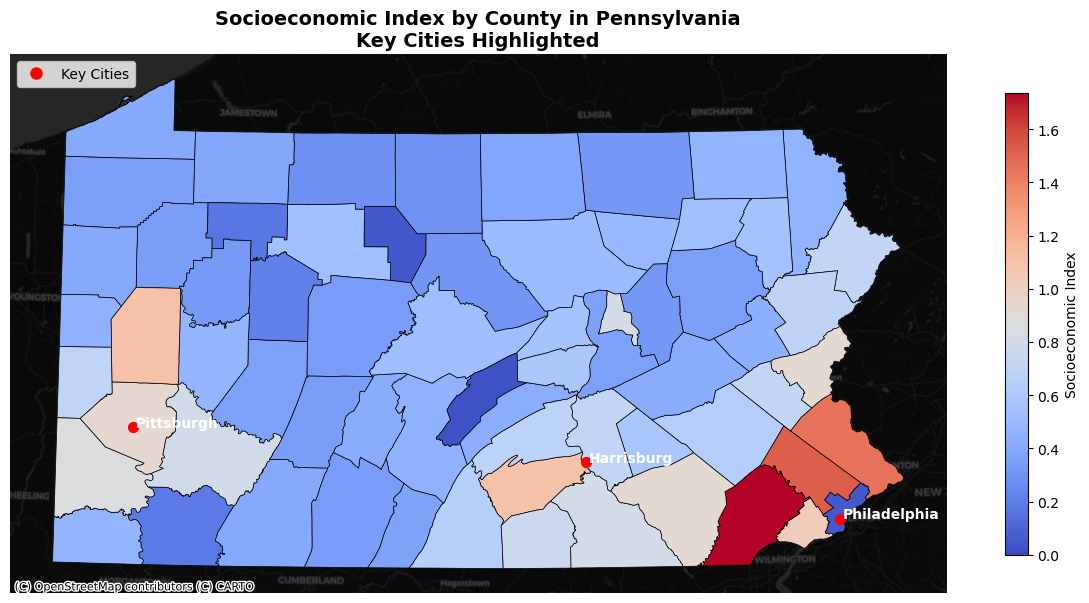

In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Ensure all variables are numeric and handle NaN values
pa_counties['Median Household Income'] = pd.to_numeric(pa_counties['Median Household Income'], errors='coerce')
pa_counties['Percent_Bachelors'] = pd.to_numeric(pa_counties['Percent_Bachelors'], errors='coerce')
pa_counties['Percent_Poverty'] = pd.to_numeric(pa_counties['Percent_Poverty'], errors='coerce')

# Fill NaN values
pa_counties['Median Household Income'].fillna(0, inplace=True)
pa_counties['Percent_Bachelors'].fillna(0, inplace=True)
pa_counties['Percent_Poverty'].fillna(0, inplace=True)

# Normalize variables
scaler = MinMaxScaler()
variables = pa_counties[['Median Household Income', 'Percent_Bachelors', 'Percent_Poverty']].copy()
variables = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns)

# Calculate Socioeconomic Index
pa_counties['Socioeconomic_Index'] = (
    variables['Median Household Income'] +
    variables['Percent_Bachelors'] -
    variables['Percent_Poverty']
)

# Ensure the geometry column in pa_counties has a CRS
if pa_counties.crs is None:
    pa_counties = pa_counties.set_crs(epsg=4326)

# Reproject pa_counties to Pennsylvania State Plane (EPSG: 2272)
pa_counties = pa_counties.to_crs(epsg=2272)

# Key cities with corrected coordinates
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Normalize the Socioeconomic Index for better visualization
norm = Normalize(vmin=pa_counties['Socioeconomic_Index'].min(), vmax=pa_counties['Socioeconomic_Index'].max())

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot counties with Socioeconomic Index
pa_counties.plot(
    column='Socioeconomic_Index',
    cmap='coolwarm',
    edgecolor='black',
    linewidth=0.5,
    norm=norm,
    legend=True,
    legend_kwds={'shrink': 0.6, 'label': "Socioeconomic Index"},
    ax=ax
)

# Plot key cities
cities_gdf.plot(ax=ax, color='red', markersize=50, label="Key Cities")

# Add city labels
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

# Add basemap for context
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for key cities
legend_elements = [Line2D([0], [0], marker='o', color='red', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Add title and clean up
plt.title("Socioeconomic Index by County in Pennsylvania\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()

This map visualizes the Socioeconomic Index across counties in Pennsylvania, with key cities (Philadelphia, Harrisburg, Pittsburgh) highlighted for context. The Socioeconomic Index is a composite score combining three key variables: Median Household Income, Percent of Adults with a Bachelor’s Degree, and Percent of Population Below the Poverty Line. 

What the Map Tells Us


Spatial Distribution of Socioeconomic Conditions:

- Higher Index Scores (e.g., Philadelphia and some surrounding counties):

- These areas have relatively high household incomes and education levels but lower poverty rates.

- These counties are likely economic hubs or affluent suburban areas.

- Lower Index Scores (e.g., rural central and western counties):

- These areas exhibit lower household incomes, lower rates of bachelor’s degree attainment, and higher poverty rates.

- These counties might face systemic socioeconomic challenges and are potential candidates for focused policy intervention.


Urban vs. Rural Divide:

- Urban areas like Philadelphia show higher socioeconomic scores due to a concentration of wealth, education, and infrastructure.

- Many rural areas show lower scores, indicating a disparity in resources and opportunities.


Regional Trends:

- Counties around Pittsburgh and Harrisburg have moderate scores, reflecting their positions as regional hubs with mixed socioeconomic conditions.

- Areas in the central and northern parts of the state (Appalachian and rural areas) tend to score lower, reinforcing the need for targeted assistance.




Identifying Priority Areas for Policy Intervention:

- Use the lowest-scoring counties as target regions for government programs, such as:

- Job training and economic development initiatives.

- Subsidies or incentives for businesses to invest in these areas.

- Educational programs to increase bachelor’s degree attainment.


Resource Allocation:

- Highlight high-scoring areas to emphasize where resources are already sufficient.

- Focus on low-scoring counties for resource reallocation (e.g., infrastructure, parks, healthcare).


Comparison with Other Indicators:

- Overlay the Socioeconomic Index with other variables like unemployment rates or park access to identify counties with compounding disadvantages.

- For instance, counties with low socioeconomic scores and high unemployment should be prioritized for job creation policies.

Policy Recommendations:

- Incorporate the map into presentations or reports to visually justify targeting low-scoring areas.

- Recommend policies tailored to the specific needs of the region (e.g., education-focused policies for areas with low bachelor’s degree attainment, poverty alleviation programs).

Stakeholder Engagement:

- Use the map to communicate to policymakers and stakeholders where disparities exist.

- Highlight the importance of addressing rural-urban disparities to ensure equitable development across Pennsylvania.




/Users/macytrout/miniforge3/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


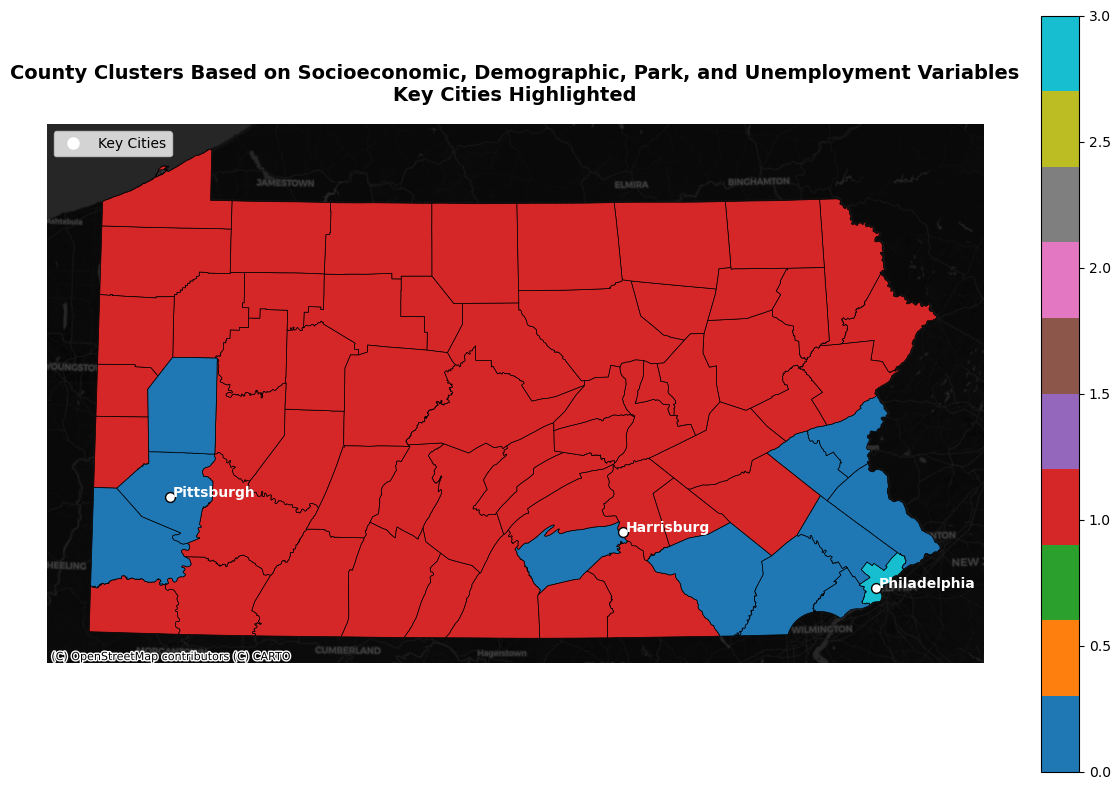

Cluster Summary:
         Socioeconomic_Index  Median Household Income  Percent_Bachelors  \
Cluster                                                                    
0                   1.763595                 1.189923           1.516475   
1                  -0.145801                 0.096878          -0.041046   
2                  -1.443756                -2.611741          -2.162843   
3                  -1.274219                -0.135270           0.716211   

         Percent_Poverty  Percent Local Park  Unemp Rate  
Cluster                                                   
0              -0.419184            1.108642   -0.276491  
1               0.332234           -0.296993    0.005827  
2              -2.383303           -0.326782   -0.043811  
3               3.021300            6.427039    3.027565  


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D

# Variables for clustering
clustering_vars = [
    'Socioeconomic_Index', 
    'Median Household Income', 
    'Percent_Bachelors', 
    'Percent_Poverty', 
    'Percent Local Park',
    'Unemp Rate'  # Added Unemployment Rate
]

# Ensure numeric and handle missing values
pa_counties[clustering_vars] = pa_counties[clustering_vars].apply(pd.to_numeric, errors='coerce')

# Fill NaNs with the median of each column
for var in clustering_vars:
    pa_counties[var].fillna(pa_counties[var].median(), inplace=True)

# Normalize variables
scaler = StandardScaler()
pa_counties[clustering_vars] = scaler.fit_transform(pa_counties[clustering_vars])

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
pa_counties['Cluster'] = kmeans.fit_predict(pa_counties[clustering_vars])

# Define corrected coordinates for key cities
key_cities = [
    {"name": "Philadelphia", "x": -75.1652, "y": 39.9526},
    {"name": "Harrisburg", "x": -76.8867, "y": 40.2732},
    {"name": "Pittsburgh", "x": -79.9959, "y": 40.4406}
]

# Convert city coordinates to geospatial points
cities_gdf = gpd.GeoDataFrame(
    key_cities,
    geometry=gpd.points_from_xy([city['x'] for city in key_cities], [city['y'] for city in key_cities]),
    crs="EPSG:4326"
).to_crs(epsg=2272)

# Plot map with clustering
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
pa_counties.plot(
    column='Cluster',
    cmap='tab10',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    ax=ax
)

# Add key cities
cities_gdf.plot(ax=ax, color='white', edgecolor='black', markersize=50, label="Key Cities")

# Annotate city names
for city, geom in zip(key_cities, cities_gdf.geometry):
    ax.text(geom.x + 5000, geom.y, city["name"], fontsize=10, color='white', fontweight='bold', ha="left")

# Add basemap for context
ctx.add_basemap(ax, crs=pa_counties.crs, source=ctx.providers.CartoDB.DarkMatter)

# Add custom legend for Key Cities
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=8, linestyle='', label='Key Cities')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Add title and clean up axes
plt.title("County Clusters Based on Socioeconomic, Demographic, Park, and Unemployment Variables\nKey Cities Highlighted", 
          fontsize=14, fontweight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()

# Print summary of clusters
cluster_summary = pa_counties.groupby('Cluster')[clustering_vars].mean()
print("Cluster Summary:")
print(cluster_summary)

Talking Points for Policymakers: Suggestions Based on Cluster Analysis

This analysis categorizes Pennsylvania counties into four distinct clusters based on their socioeconomic index, median household income, educational attainment, poverty rates, unemployment, and local park coverage. These clusters help us identify areas where government resources could be strategically allocated to address disparities.

Cluster Insights and Policy Recommendations

Cluster 0: Prosperous Counties

Characteristics:

- High socioeconomic index.

- Above-average household income and educational attainment.

- Low poverty and unemployment rates.

- Strong local park coverage.


Policy Recommendations:

- These counties are thriving. Policies should focus on maintaining existing resources and infrastructure.

- Expand innovative programs such as workforce training for high-skill industries and renewable energy investments to keep these areas competitive.


Cluster 1: Stable but Vulnerable Counties

Characteristics:

- Moderate socioeconomic indicators.

- Median household income and education slightly below Cluster 0.

- Poverty and unemployment are modest but rising in some areas.
- Below-average local park coverage.

Policy Recommendations:

- Invest in green infrastructure and park creation to improve quality of life and attract economic growth.

- Support small business incentives and workforce training programs to bolster economic resilience.

- Target housing affordability programs to address growing economic pressures.


Cluster 2: Economically Struggling Rural Counties

Characteristics:

- Low socioeconomic index, median household income, and educational attainment.

- Poverty is present but less concentrated (likely in rural areas).

- Limited local park coverage, suggesting a lack of recreational opportunities.

Policy Recommendations:

- Prioritize economic development programs, including small business grants and rural broadband expansion.

- Expand access to higher education and job training programs to increase educational attainment.

- Improve park and green space accessibility to enhance community well-being and attract residents and visitors.


Cluster 3: Counties in Crisis

Characteristics:

- Lowest socioeconomic index, coupled with the highest poverty and unemployment rates.

- Surprisingly high local park coverage, but these areas may lack the capacity to maintain parks effectively.


Policy Recommendations:

- Implement immediate poverty alleviation programs, including job creation initiatives and affordable housing.

- Provide direct state funding to maintain parks and utilize them for community-building activities.

- Focus on long-term educational and workforce development to address systemic poverty and unemployment.

Broader Policy Implications

Targeted Resource Allocation:

- Clusters 2 and 3 should be prioritized for state and federal resources to address entrenched economic disparities.

- Parks in Cluster 3, while abundant, should be maintained through state support to ensure accessibility and functionality.

Regional Collaboration:

- Use thriving counties in Cluster 0 as models for economic development and park infrastructure improvements in struggling areas.

- Equity in Policy Implementation:
    
- Ensure that policies account for the unique challenges of rural areas (Cluster 2) versus more urbanized high-poverty areas (Cluster 3).

This cluster analysis highlights the need for nuanced, data-driven policies tailored to the strengths and challenges of each cluster. By targeting investments where they are most needed, the state can foster more equitable development and improve outcomes for residents statewide.

Within-Cluster Characteristics Summary:
         Median Household Income ($)  Population Below Poverty Line (%)  \
Cluster                                                                   
0                           1.189923                       43325.454545   
1                           0.096878                       11891.781818   
2                          -2.611741                                NaN   
3                          -0.135270                      351811.000000   

         Bachelor's Degree Holders (%)  Local Park Coverage (%)  \
Cluster                                                           
0                             1.516475                 1.108642   
1                            -0.041046                -0.296993   
2                            -2.162843                -0.326782   
3                             0.716211                 6.427039   

         Unemployment Rate (%)  Total Population  
Cluster                                           
0   

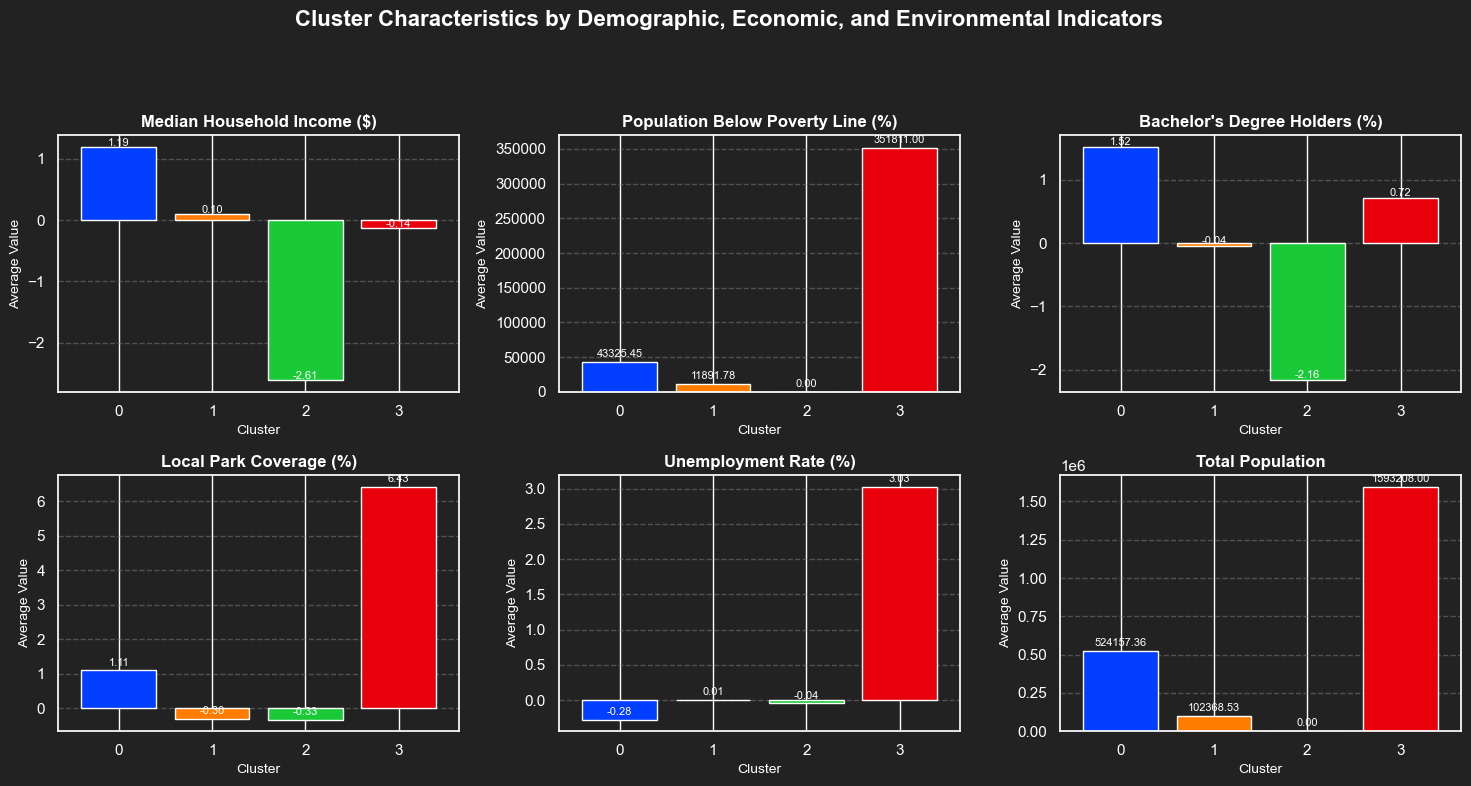

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by cluster and calculate the mean for relevant variables
cluster_summary = pa_counties.groupby('Cluster')[[
    'Median Household Income', 
    'Population Below Poverty Line', 
    'Percent_Bachelors', 
    'Percent Local Park',
    'Unemp Rate',
    'Total Population'
]].mean()

# Rename columns for clarity
cluster_summary = cluster_summary.rename(columns={
    'Median Household Income': 'Median Household Income ($)',
    'Population Below Poverty Line': 'Population Below Poverty Line (%)',
    'Percent_Bachelors': "Bachelor's Degree Holders (%)",
    'Percent Local Park': 'Local Park Coverage (%)',
    'Unemp Rate': 'Unemployment Rate (%)',
    'Total Population': 'Total Population'
})

print("Within-Cluster Characteristics Summary:")
print(cluster_summary)

# Set dark theme for the plots
sns.set_theme(style="darkgrid", rc={"axes.facecolor": "#222222", "figure.facecolor": "#222222"})

sns.set_palette("bright")
colors = sns.color_palette("bright", n_colors=len(cluster_summary))

# Create bar plots for each variable
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Cluster Characteristics by Demographic, Economic, and Environmental Indicators", fontsize=16, fontweight='bold', color='white')

variables = cluster_summary.columns
for ax, var in zip(axes.flatten(), variables):
    bars = cluster_summary[var].plot(kind='bar', ax=ax, color=colors, width=0.8)
    ax.set_title(var, fontsize=12, fontweight='bold', color='white')
    ax.set_xlabel("Cluster", fontsize=10, color='white')
    ax.set_ylabel("Average Value", fontsize=10, color='white')
    ax.tick_params(axis='x', rotation=0, colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(axis='y', linestyle='--', alpha=0.5, color='gray')  # Add gridlines

    # Add value labels on top of bars
    for bar in bars.patches:
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.02 * max(cluster_summary[var]), 
            f"{bar.get_height():.2f}", 
            ha='center', fontsize=8, color='white'
        )

# Hide any unused subplots
for ax in axes.flatten()[len(variables):]:
    ax.axis("off")
    ax.set_facecolor('#222222')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

Based on the clustering analysis and visualizations of demographic, economic, and environmental characteristics across Pennsylvania counties, here are the key insights and policy recommendations:

Cluster 0 (Blue)

- Characteristics: This cluster shows high median household income and bachelor’s degree attainment, relatively low poverty rates, and moderate park coverage. Unemployment rates are below average, and the total population is mid-sized.

- Policy Recommendation: Counties in this cluster appear economically stable with access to educational attainment and moderate green spaces. Policies could focus on maintaining economic resilience and enhancing recreational spaces to sustain quality of life.

Cluster 1 (Orange)

- Characteristics: This cluster has average household income and unemployment rates, relatively lower bachelor’s degree attainment, and minimal park coverage. Poverty rates are slightly above the mean.

- Policy Recommendation: These areas would benefit from educational initiatives to increase higher education attainment and investments in green infrastructure, such as parks, to improve community well-being and attract residents.

Cluster 2 (Green)

- Characteristics: This cluster faces significant economic challenges, with the lowest median income, high poverty levels, and extremely low educational attainment. Park coverage is minimal, and unemployment rates are average.


Policy Recommendation: These counties should be prioritized for resource allocation. Policies should include:

- Economic development programs, such as job creation initiatives and small business support.

- Expansion of higher education opportunities and workforce training programs.

- Investment in parks and green spaces to provide recreational opportunities and improve quality of life.

Cluster 3 (Red)

Characteristics: This cluster is defined by a large population and extreme disparities. It has the highest unemployment rate and a very high poverty rate, but also notable park coverage and higher bachelor’s degree attainment.

Policy Recommendation: Policies should aim to reduce poverty and unemployment, focusing on:

- Workforce development and job creation initiatives.

- Support for affordable housing and anti-poverty programs.

- Leveraging existing park resources to promote tourism and community activities.

Summary and Policy Focus

The clusters highlight areas of Pennsylvania that vary widely in socioeconomic and environmental characteristics:

- Clusters 2 and 3 are clear areas of need, with high poverty and unemployment rates, calling for targeted interventions.

- Clusters 0 and 1, while more stable, would benefit from strategic investments in green infrastructure and educational initiatives to maintain and enhance their resilience.

This analysis helps policymakers identify and address disparities across counties, ensuring equitable distribution of resources and tailored policy actions to foster economic and social stability statewide.